In [1]:
# I didn't put any google trends data here since we are only exploring amazon reviews in this notebook.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
    
    
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline


def GetMergedAmazonDataFrames():
#     files_to_use = [r'data\AirPods Pro.csv', r'data\Elite 75t.csv',r'data\Free.csv',
#                    r'data\Galaxy Buds Plus.csv',r'data\M-200.csv',r'data\NC700.csv',
#                    r'data\Soundcore Liberty 2 Pro.csv',r'data\Soundcore Liberty Air 2.csv',r'data\Soundcore Life Q20.csv',
#                    r'data\WF-1000XM3.csv']
    files_to_use = [r'data\AirPods Pro.csv', r'data\Elite 75t.csv',r'data\Free.csv',
                   r'data\Galaxy Buds Plus.csv',r'data\NC700.csv',
                   r'data\Soundcore Liberty 2 Pro.csv',r'data\Soundcore Liberty Air 2.csv',r'data\Soundcore Life Q20.csv',
                   r'data\WF-1000XM3.csv']
    
    amzn_df = pd.read_csv(files_to_use[0],  parse_dates=False)
    for file in files_to_use[1:]:
        df = pd.read_csv(file,  parse_dates=False)
#         amzn_df = pd.merge(amzn_df, df, how='outer',on='review_date')
        amzn_df = pd.concat([amzn_df,df],sort=False)
        
    amzn_df['review_date'] = pd.to_datetime(amzn_df['review_date'], format='%Y-%m-%d')
    amzn_df = amzn_df[['Manufacturer', 'ProductName', 'review_rating', 'verified_purchase',
       'review_date', 'review_title', 'review_text']]
    return amzn_df
    

import numpy as np

def GetAmazonTextReviewsDf():
    ### This function is used to prepare 
    #   the data frame to word and text analysis.. ####
    amzn_df = GetMergedAmazonDataFrames()
    columns = ['Manufacturer', 'ProductName', 'review_rating', 'verified_purchase',
       'review_date', 'review_title', 'review_text']
    
    amzn_df=amzn_df[columns]
    return amzn_df
#     amzn_df['totalReviews'] =
    
def GetAmazonNumericalReviewsDf():
    amzn_df = GetMergedAmazonDataFrames()
    columns = ['Manufacturer', 'ProductName', 'review_rating', 'verified_purchase',
       'review_date']
    
    amzn_df=amzn_df[columns]
    # split into two data sets for purchased and not purchased.
    amzn_purchased = amzn_df.where(amzn_df['verified_purchase']== 1).dropna()
    amzn_notPurchased = amzn_df.where(amzn_df['verified_purchase']== 0).dropna()
    
    tempdf = None
    for product in amzn_purchased['ProductName'].unique():
        df = amzn_purchased.where(amzn_purchased['ProductName'] == product).dropna()
        
        manufacturer = df['Manufacturer'].unique()[0]
        df= df[['review_rating','review_date']]
        
        dfCount = df
        df = df.set_index('review_date').resample('W-SAT').mean().reset_index()#.agg(['mean','count']).reset_index()
#         df['review_rating'] = df['review_rating'].fillna(0)
        df['review_rating_norm'] = Normalize(df['review_rating'].fillna(df['review_rating'].mean()))
        df['ProductName'] = df['review_rating'].apply(lambda x: product)
        df['Manufacturer'] = df['review_rating'].apply(lambda x: manufacturer)
        df['verified_purchase'] = df['review_rating'].apply(lambda x: '1')
        df['count'] = dfCount[['review_rating','review_date']].set_index('review_date').resample('W-SAT').count().reset_index()['review_rating']
#         print(df.head())
        if tempdf is None:
            tempdf = df
        else:
            tempdf = pd.concat([tempdf, df])
            
    
    for product in amzn_notPurchased['ProductName'].unique():
        df = amzn_notPurchased.where(amzn_notPurchased['ProductName'] == product).dropna()
        
        manufacturer = df['Manufacturer'].unique()[0]
        df= df[['review_rating','review_date']]
        
        dfCount = df
        
        
        df = df.set_index('review_date').resample('W-SAT').mean().reset_index()#.agg(['mean','count']).reset_index()
#         df['review_rating'] = df['review_rating'].fillna(0)
        df['review_rating_norm'] = Normalize(df['review_rating'].fillna(df['review_rating'].mean()))
        df['ProductName'] = df['review_rating'].apply(lambda x: product)
        df['Manufacturer'] = df['review_rating'].apply(lambda x: manufacturer)
        df['verified_purchase'] = df['review_rating'].apply(lambda x: '0')
        df['count'] = dfCount[['review_rating','review_date']].set_index('review_date').resample('W-SAT').count().reset_index()['review_rating']
        
#         print(df.head())
        if tempdf is None:
            tempdf = df
        else:
            tempdf = pd.concat([tempdf, df])
            
    return tempdf
    

In [2]:
# Math functions

In [3]:
def Normalize(array):
    return array / np.linalg.norm(array, ord=1)
    
# Sav-golay filter for averaging.
def savGolay(array, window = 9, order =7):
    from scipy.ndimage import convolve1d
    from scipy.signal import savgol_coeffs, savgol_filter
    from scipy.signal._savitzky_golay import _polyder
    return savgol_filter(array, window, order)
   
# Simple Moving Average used in financial data.
def SMA(pandas_df_daily,columnName, dayWindowSize=20):
    daily_close_df = pandas_df_daily[columnName].copy()
    return daily_close_df.rolling(dayWindowSize).mean()

# Functions for working with words

In [4]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

def TokenizeText(text):
    from nltk.tokenize import RegexpTokenizer
    tokenizer = RegexpTokenizer(r'\w+')
#     text = "This is my text. It includes commas, question marks? and other stuff. Also U.S..".lower()
    tokens = tokenizer.tokenize(text)
    return tokens

def GetWordsAndTheirTags(text):
    text = CleanText(text)
    tokens = TokenizeText(text)
    return nltk.pos_tag(tokens)

def CleanText(text):
    text=str(text)
    text= text.lower().replace("wouldn\'t","would not")
    return text
def helperGetWordsWithTokenType(text, t):   
# #     print(nltk.help.upenn_tagset('PRP$'))
# #     print(text)
#     text = CleanText(text)
#     tokens = TokenizeText(text)
# #     for duo in nltk.pos_tag(tokens):
# #         if duo[1] =='JJ': # adjectives
# #             print(duo)           
#     return [x[0] for x in nltk.pos_tag(tokens) if x[1]=='JJ']
    tokens = TokenizeText(text)          
    return [x[0] for x in nltk.pos_tag(tokens) if x[1] in t]
    
def GetAdjectivesFromText(text):
    text = CleanText(text)
    return helperGetWordsWithTokenType(text,['JJ'])

def GetNounsFromText(text):
    text = CleanText(text)
    return helperGetWordsWithTokenType(text,['NN','NNS'])

def GetVerbssFromText(text):
    text = CleanText(text)
    # Verbs are tricky... we have to add a 'to' before every word in the text, so we can convert words to verbs
    # this will return any words that can be interpreted as a verb even if not used in the text that way.
    # it's difficult to know by the text alone if a word is a verb or not, so this will force it to a verb.
    
    tokens = TokenizeText(text)       
    words = [ 'to '+ x for x in tokens]
#     print(' '.join(words))
    return helperGetWordsWithTokenType(' '.join(words),['VBZ','VB'])

def GetWordPairs(text):
    text = CleanText(text)
    tokens = TokenizeText(text)
    
    #we need to create a new array with pairs of the words in the tokens array.

    pairs = []
    for i in range(0,len(tokens)-1,1):
        firstWord = tokens[i]
        secondWord = tokens[i+1]
        pairs.append(set([firstWord,secondWord]))
    #     print(set([firstWord,secondWord]))
#     print(pairs)
    return pairs

def GetWordTriplets(text):
    text = CleanText(text)
    tokens = TokenizeText(text)
    
    #we need to create a new array with pairs of the words in the tokens array.

    pairs = []
    for i in range(0,len(tokens)-2,1):
        firstWord = tokens[i]
        secondWord = tokens[i+1]
        thirdWord = tokens[i+2]
        pairs.append(set([firstWord,secondWord,thirdWord]))
    #     print(set([firstWord,secondWord]))
#     print(pairs)
    return pairs

from collections import defaultdict
def count_frequency(word_list):
    """ Function input: list object contains strings of individual words.
        Function output: defaultdict() object containing {word, frequency} pairs. """

    freq_counts = defaultdict(int)
    
    for word in word_list:
        freq_counts[word] += 1

    return freq_counts

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\AngryGamers\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\AngryGamers\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [5]:
# GetVerbssFromText("This is my hate text. It includes commas, question marks? dog and other stuff. Also U.S..wouldn't it be great")
# GetAdjectivesFromText("This is my text. It includes commas, question marks? and other stuff. Also U.S..".lower())
# #     print(duo[1])
# # tokens
# GetWordsAndTheirTags("This is my hate text. It includes commas, question marks? dog and other stuff. Also U.S..wouldn't it be great")

# text = CleanText("This is my hate text. It includes commas, question marks? dog and other stuff. Also U.S..wouldn't it be great")
# tokens = TokenizeText(text)  

# pairs = []
# for i in range(0,len(tokens)-1,1):
#     firstWord = tokens[i]
#     secondWord = tokens[i+1]
#     pairs.append(set([firstWord,secondWord]))
# #     print(set([firstWord,secondWord]))
# print(pairs)
# # tokens.rotate(1)
GetWordPairs("This is my hate text. It includes commas, question marks? dog and other stuff. Also U.S..wouldn't it be great")

[{'is', 'this'},
 {'is', 'my'},
 {'hate', 'my'},
 {'hate', 'text'},
 {'it', 'text'},
 {'includes', 'it'},
 {'commas', 'includes'},
 {'commas', 'question'},
 {'marks', 'question'},
 {'dog', 'marks'},
 {'and', 'dog'},
 {'and', 'other'},
 {'other', 'stuff'},
 {'also', 'stuff'},
 {'also', 'u'},
 {'s', 'u'},
 {'s', 'would'},
 {'not', 'would'},
 {'it', 'not'},
 {'be', 'it'},
 {'be', 'great'}]

In [6]:
# Functions to tweak pandas data frames.
def AddAdjectiveNounsVerbsToDF(df, textColumn):
    df = df.copy()
#     amzn_df['text_adjectives'] =amzn_df['review_text'].apply(lambda x: GetAdjectivesFromText(str(x).lower()))
#     amzn_df['text_nouns'] =amzn_df['review_text'].apply(lambda x: GetNounsFromText(str(x).lower()))
#     amzn_df['text_verbs'] =amzn_df['review_text'].apply(lambda x: GetVerbssFromText(str(x).lower()))
    df['text_adjectives'] =df[textColumn].apply(lambda x: GetAdjectivesFromText(str(x).lower()))
    df['text_adjectives'] = df['text_adjectives'].apply(lambda row: set([  x for x in row if(len(x) >1)]) )
    
    df['text_nouns'] =df[textColumn].apply(lambda x: GetNounsFromText(str(x).lower()))
    df['text_nouns'] = df['text_nouns'].apply(lambda row: set([  x for x in row if(len(x) >1)]) )
    
    df['text_verbs'] =df[textColumn].apply(lambda x: GetVerbssFromText(str(x).lower()))
    df['text_verbs'] = df['text_verbs'].apply(lambda row: set([  x for x in row if(len(x) >1)]) )
    
    # create word pairs.
    df['text_pairs'] = df[textColumn].apply(lambda row: GetWordPairs(row))
    df['text_triplets'] = df[textColumn].apply(lambda row: GetWordTriplets(row))
    return df

def GetDataframeOfWords(pandasdf, textColumn):
#     pandasdf['words'] = CreateListForColumn(pandasdf, textColumn)
    pandasdf['words']=pandasdf[textColumn]
    wordArray = pandasdf[pandasdf['words'].map(lambda d: len(d)) > 0]['words'].values
    words = []
    for wordlist in wordArray:
        words.extend(wordlist)
    wordDictionary = count_frequency(words)
    
    df = pd.DataFrame.from_dict(wordDictionary, orient='index',
                       columns=['count']).reset_index()
    df = df.rename(columns={"index": "word"})
    df = df.sort_values(by=['count'], ascending=False)
    
    totalWords = df['count'].sum()
    df['usage'] = df['count']/totalWords
#     df = df.set_index('word')
    
    return df

In [7]:
amzn_df = GetAmazonTextReviewsDf()
amzn_df = AddAdjectiveNounsVerbsToDF(amzn_df,'review_text')
amzn_df.head()

,Manufacturer,ProductName,review_rating,verified_purchase,review_date,review_title,review_text,text_adjectives,text_nouns,text_verbs,text_pairs,text_triplets
0,Apple,AirPods Pro,5,0,2019-10-30,Airpods Pro deliver😎,This airpods pro do exactly what apple said th...,"{new, different, many}","{resistant, money, design, thats, tax, noise, ...","{ear, like, correctly, worth, design, buds, do...","[{this, airpods}, {pro, airpods}, {do, pro}, {...","[{pro, this, airpods}, {do, pro, airpods}, {do..."
1,Apple,AirPods Pro,4,0,2019-10-30,List of Features/Changes compared to Airpods (v2),"Like iphone 11 Pro, Macbook Pro, Airpad Pro; t...","{battery, social, ear, old, replacement, rough...","{anytime, piece, lows, quality, pair, hours, p...","{go, anytime, piece, forward, like, quality, p...","[{iphone, like}, {11, iphone}, {11, pro}, {mac...","[{11, iphone, like}, {11, iphone, pro}, {macbo..."
2,Apple,AirPods Pro,3,0,2019-10-30,Cool but expensive,First review yeh heard about these excited but...,{excited},"{review, dollars, airpods}","{review, first, get, heard, yeh, like, less}","[{review, first}, {review, yeh}, {yeh, heard},...","[{review, yeh, first}, {review, yeh, heard}, {..."
3,Apple,AirPods Pro,5,0,2019-10-30,Lit,They fire,{},{},{fire},"[{fire, they}]",[]
4,Apple,AirPods Pro,5,1,2019-10-31,Saved my marriage,"With the new transparency mode, I can listen t...",{new},"{transparency, street, boys, music, tim, cook,...","{transparency, be, street, listen, ran, boys, ...","[{the, with}, {new, the}, {transparency, new},...","[{new, the, with}, {transparency, new, the}, {..."


In [57]:
amzn_df.head()

,Manufacturer,ProductName,review_rating,verified_purchase,review_date,review_title,review_text,text_adjectives,text_nouns,text_verbs,text_pairs,text_triplets
0,Apple,AirPods Pro,5,0,2019-10-30,Airpods Pro deliver😎,This airpods pro do exactly what apple said th...,"{new, different, many}","{resistant, money, design, thats, tax, noise, ...","{ear, like, correctly, worth, design, buds, do...","[{this, airpods}, {pro, airpods}, {do, pro}, {...","[{pro, this, airpods}, {do, pro, airpods}, {do..."
1,Apple,AirPods Pro,4,0,2019-10-30,List of Features/Changes compared to Airpods (v2),"Like iphone 11 Pro, Macbook Pro, Airpad Pro; t...","{battery, social, ear, old, replacement, rough...","{anytime, piece, lows, quality, pair, hours, p...","{go, anytime, piece, forward, like, quality, p...","[{iphone, like}, {11, iphone}, {11, pro}, {mac...","[{11, iphone, like}, {11, iphone, pro}, {macbo..."
2,Apple,AirPods Pro,3,0,2019-10-30,Cool but expensive,First review yeh heard about these excited but...,{excited},"{review, dollars, airpods}","{review, first, get, heard, yeh, like, less}","[{review, first}, {review, yeh}, {yeh, heard},...","[{review, yeh, first}, {review, yeh, heard}, {..."
3,Apple,AirPods Pro,5,0,2019-10-30,Lit,They fire,{},{},{fire},"[{fire, they}]",[]
4,Apple,AirPods Pro,5,1,2019-10-31,Saved my marriage,"With the new transparency mode, I can listen t...",{new},"{transparency, street, boys, music, tim, cook,...","{transparency, be, street, listen, ran, boys, ...","[{the, with}, {new, the}, {transparency, new},...","[{new, the, with}, {transparency, new, the}, {..."


In [ ]:
# https://www.mikulskibartosz.name/how-to-split-a-list-inside-a-dataframe-cell-into-rows-in-pandas/

# GetDataframeOfWords(amzn_df,'text_adjectives')
# GetDataframeOfWords(amzn_df,'text_verbs')


# GetDataframeOfWords(amzn_df[:50],'text_pairs')
# from collections import Counter
# Counter(amzn_df[:50]['text_pairs'])

# amzn_df[:50]['text_pairs'].value_counts()

# data = amzn_df[40:50][['review_date','verified_purchase','text_pairs']]
# data = amzn_df[40:50]

# data['text_pairs']#.apply(lambda x: x[0])

# data=data.reset_index()
# # data.where(data['text_pairs'])

# ### This is a bit tricky what this is doing...###
# #  we create a new temp column, which is where we get the values from that we'll be working with.
# #  take the column and dumping that into it's own data frame, which makes a bunch of columns. (from array to df)
# #  merge the the new dataframe with all of our many columns back into the original data frame with columns we want to keep.
# #  we remove the temp column. This temp column would melt into our final column we are making...
# #     the issue I had was without removing the column I could get pairs merged with other pairs, wo they ended up being 
# #     sets of 3+ merged with who knows what, which isn't what I wanted.
# #  there is a variable column that's created in this process which we can remove.
# data["tempPairs"] = data["text_pairs"]
# data = data['text_pairs'].apply(pd.Series)\
#     .merge(data, right_index = True, left_index = True) \
#     .drop(["tempPairs"], axis = 1)\
#     .drop(["text_pairs"], axis = 1)\
#     .melt(id_vars = ['review_date', 'verified_purchase'], value_name = "pairs") \
#     .drop("variable", axis = 1)

def GetReviewPairsCounts(df, pairsColumn, columnstoKeep=['review_date', 'verified_purchase']):
    data = df.copy()
    data["tempPairs"] = data[pairsColumn]
    data = data[pairsColumn].apply(pd.Series)\
    .merge(data, right_index = True, left_index = True) \
    .drop(["tempPairs"], axis = 1)\
    .drop([pairsColumn], axis = 1)\
    .melt(id_vars =columnstoKeep, value_name = "pairs") \
    .drop("variable", axis = 1).dropna()
    
    
    # count should be a ratio of the current elem/total sets. NOTE: can't really count them here...value too small.
    totalReview= len(df['verified_purchase'])
    
    
    #NOTE: WE HAVE TO DO THE RATIO FOR THE NUMBER OF REVIEWS THAT PRODUCT HAS?
    
    
    
    data['count'] = data['verified_purchase'].apply(lambda x: 1/totalReview)
#     data['count'] = data['verified_purchase'].apply(lambda x: 1)
    
    # we can't group by a set, so we need to make it a string like object, so we can hash it.
    data['pairs_hashable'] = data['pairs'].apply(lambda x: repr(x))
    
#     countsdf = data.pairs.value_counts().reset_index().rename(columns={'pairs':'total','index':'pairs'})
    
#     pd.merge(data,countsdf, on='pairs', )
    
    return data

def CreateFullDFOfProductsAndWordPairs(amzn_Df):
    ### this function will try to keep the product name field and format a dataframe that we can easily parse
    final_df = None
    for elem in amzn_df['ProductName'].unique():
        
        df = amzn_df.where(amzn_df['ProductName'] == elem).dropna()
        df = df[['review_date','verified_purchase','text_pairs']]
        df = GetReviewPairsCounts(df, 'text_pairs',['review_date', 'verified_purchase'] )
        df['ProductName'] = df['pairs'].apply(lambda x: elem)
        if final_df is None:
            final_df=df
        else:
            final_df = pd.concat([final_df,df])
            
    return final_df

# data = amzn_df[['review_date','verified_purchase','text_pairs']]
# data = GetReviewPairsCounts(data, 'text_pairs',['review_date', 'verified_purchase'] )

# Single Words

This section will cover analysis of only single words found in the list. We will take a top down approach.<br><br>
<ul>
    <li> high reviews are above 3 and low reviews are less than 3, what are the unique words between the high and low?</li>
    <li> what are the unique words between the purchased and not purchased?</li>
    <li> what are the unique words between the products?</li>



</ul>

In [72]:
print(amzn_df.columns)
amzn_df.head()

Index(['Manufacturer', 'ProductName', 'review_rating', 'verified_purchase',
       'review_date', 'review_title', 'review_text', 'text_adjectives',
       'text_nouns', 'text_verbs', 'text_pairs', 'text_triplets'],
      dtype='object')


,Manufacturer,ProductName,review_rating,verified_purchase,review_date,review_title,review_text,text_adjectives,text_nouns,text_verbs,text_pairs,text_triplets
0,Apple,AirPods Pro,5,0,2019-10-30,Airpods Pro deliver😎,This airpods pro do exactly what apple said th...,"{new, different, many}","{resistant, money, design, thats, tax, noise, ...","{ear, like, correctly, worth, design, buds, do...","[{this, airpods}, {pro, airpods}, {do, pro}, {...","[{pro, this, airpods}, {do, pro, airpods}, {do..."
1,Apple,AirPods Pro,4,0,2019-10-30,List of Features/Changes compared to Airpods (v2),"Like iphone 11 Pro, Macbook Pro, Airpad Pro; t...","{battery, social, ear, old, replacement, rough...","{anytime, piece, lows, quality, pair, hours, p...","{go, anytime, piece, forward, like, quality, p...","[{iphone, like}, {11, iphone}, {11, pro}, {mac...","[{11, iphone, like}, {11, iphone, pro}, {macbo..."
2,Apple,AirPods Pro,3,0,2019-10-30,Cool but expensive,First review yeh heard about these excited but...,{excited},"{review, dollars, airpods}","{review, first, get, heard, yeh, like, less}","[{review, first}, {review, yeh}, {yeh, heard},...","[{review, yeh, first}, {review, yeh, heard}, {..."
3,Apple,AirPods Pro,5,0,2019-10-30,Lit,They fire,{},{},{fire},"[{fire, they}]",[]
4,Apple,AirPods Pro,5,1,2019-10-31,Saved my marriage,"With the new transparency mode, I can listen t...",{new},"{transparency, street, boys, music, tim, cook,...","{transparency, be, street, listen, ran, boys, ...","[{the, with}, {new, the}, {transparency, new},...","[{new, the, with}, {transparency, new, the}, {..."


In [116]:

def SingleWords_df(df):
    data = df.copy()
    data = data[['verified_purchase','review_date', 'text_adjectives']]
    # highAdjectivesRanking['text_adjectives'] = highAdjectivesRanking['text_adjectives'].apply(lambda x: repr(x))
    data["tempPairs"] = data["text_adjectives"]
    data = data['text_adjectives'].apply(lambda x: pd.Series(list(x)))\
        .merge(data, right_index = True, left_index = True) \
        .drop(["tempPairs"], axis = 1)\
        .drop(["text_adjectives"], axis = 1)\
        .melt(id_vars = ['review_date', 'verified_purchase'], value_name = "words") \
        .drop("variable", axis = 1).dropna()
    
    
    # count should be a ratio of the current elem/total sets. NOTE: can't really count them here...value too small.
    totalReview= len(df['verified_purchase'])
    data['count'] = data['verified_purchase'].apply(lambda x: 1/totalReview)
    
    return data

lowAdjectivesRanking = amzn_df.where(amzn_df['review_rating'] < 2).dropna()
lowAdjectivesRanking = SingleWords_df(lowAdjectivesRanking)

highAdjectivesRanking = amzn_df.where(amzn_df['review_rating'] > 4).dropna()
highAdjectivesRanking = SingleWords_df(highAdjectivesRanking)

In [119]:
adjCount_temp = highAdjectivesRanking[['words','count']].groupby(['words']).sum().sort_values(by='count',ascending=False).reset_index()
adjCount_temp2 = lowAdjectivesRanking[['words','count']].groupby(['words']).sum().sort_values(by='count',ascending=False).reset_index()

intersection = adjCount_temp.merge(adjCount_temp2, left_on='words', right_on='words', how='inner')
intersection
# highAdjectivesRanking['words'].isin(intersection['words'].unique())
top_adj_words_df = highAdjectivesRanking[~highAdjectivesRanking['words'].isin(intersection['words'].unique())].groupby('words').sum().sort_values(by='count',ascending=False)
lower_adj_words_df = lowAdjectivesRanking[~lowAdjectivesRanking['words'].isin(intersection['words'].unique())].groupby('words').sum().sort_values(by='count',ascending=False)

#NOTE: the intersection or ratings 2-4 don't have any good unique words to use, so by using the extremes we can find more uniqueness.
# intersection



,words,count_x,count_y
0,great,1.414493,0.226009
1,good,1.003382,0.255605
2,comfortable,0.502053,0.057399
3,sound,0.487802,0.137220
4,ear,0.449034,0.136323
5,other,0.401691,0.209865
6,easy,0.314372,0.038565
7,excellent,0.267995,0.025112
8,nice,0.259420,0.045740
9,little,0.250121,0.052018


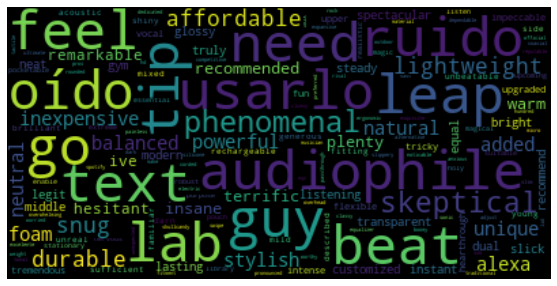

In [138]:
wordsDump = highAdjectivesRanking[~highAdjectivesRanking['words'].isin(intersection['words'].unique())].groupby('words').sum().sort_values(by='count',ascending=False).reset_index()
text = wordsDump['words'].apply(lambda x: str(x)).values

text = ' '.join(text)
# txt = "The rain in Spain"
# x = re.search("^The.*Spain$", txt)

# import re
# for elem in text:
#     print(re.findall(r"\w[\w']+", elem))
    
    
from wordcloud import WordCloud

# Generate a word cloud image
# wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure(figsize=(20,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [123]:
.merge(df2, left_on='lkey', right_on='rkey')

SyntaxError: invalid syntax (<ipython-input-123-83461d595e35>, line 1)

## Word pairs entire list of reviews

This will create a data frame of all the reviews. We want to see overall what are the different words between the purchased and not purchased sets?

In [66]:
# data

wordPairsAllReviews_df= CreateFullDFOfProductsAndWordPairs(amzn_df)
wordPairsAllReviews_df.head()
# We want ProductName, Manufacturer, pairs_hashable, sum
# highRatings = data.where(data['review_rating'] >= 4).dropna()
# lowRatings = data.where(data['review_rating'] <= 2).dropna()
# lowRatings
# lowRatings.groupby(['verified_purchase','ProductName','Manufacturer','pairs_hashable']).sum()

# data[['pairs_hashable','count']].groupby('pairs_hashable').sum()


# data[['pairs','count']].groupby('pairs').sum()

,review_date,verified_purchase,pairs,count,pairs_hashable,ProductName
0,2019-10-30,0.0,"{this, airpods}",0.000242,"{'this', 'airpods'}",AirPods Pro
1,2019-10-30,0.0,"{iphone, like}",0.000242,"{'iphone', 'like'}",AirPods Pro
2,2019-10-30,0.0,"{review, first}",0.000242,"{'review', 'first'}",AirPods Pro
3,2019-10-30,0.0,"{fire, they}",0.000242,"{'fire', 'they'}",AirPods Pro
4,2019-10-31,1.0,"{the, with}",0.000242,"{'the', 'with'}",AirPods Pro


In [68]:
overallPopularwords= wordPairsAllReviews_df.groupby(['pairs_hashable','verified_purchase']).sum().reset_index()


overallPopularwords_notPurchased = overallPopularwords.where(overallPopularwords['verified_purchase'] == 0).dropna()
overallPopularwords_notPurchased = overallPopularwords_notPurchased.sort_values(by=['count'],ascending =False).reset_index().drop(columns=['index'])

overallPopularwords_purchased = overallPopularwords.where(overallPopularwords['verified_purchase'] == 1).dropna()
overallPopularwords_purchased = overallPopularwords_purchased.sort_values(by=['count'],ascending =False).reset_index().drop(columns=['index'])

# now we have two datasets one with purchased the other not purchased.

In [69]:
overallPopularwords_notPurchased.head(10)

,pairs_hashable,verified_purchase,count
0,"{'of', 'the'}",0.0,0.819273
1,"{'the', 'on'}",0.0,0.625983
2,"{'i', 'have'}",0.0,0.561268
3,"{'the', 'with'}",0.0,0.546574
4,"{'sound', 'the'}",0.0,0.531527
5,"{'the', 'in'}",0.0,0.522295
6,"{'sound', 'quality'}",0.0,0.508188
7,"{'i', 'm'}",0.0,0.498588
8,"{'the', 'and'}",0.0,0.487143
9,"{'s', 'it'}",0.0,0.475692


In [70]:
overallPopularwords_purchased.head(10)

,pairs_hashable,verified_purchase,count
0,"{'sound', 'quality'}",1.0,1.910665
1,"{'sound', 'the'}",1.0,1.819174
2,"{'i', 'have'}",1.0,1.738156
3,"{'of', 'the'}",1.0,1.697762
4,"{'the', 'in'}",1.0,1.507372
5,"{'the', 'and'}",1.0,1.476486
6,"{'i', 'm'}",1.0,1.414304
7,"{'battery', 'life'}",1.0,1.355736
8,"{'the', 'on'}",1.0,1.354728
9,"{'t', 'don'}",1.0,1.241906


In [ ]:
# now we need to merge the two verified _purchase lists into a data frame. We don't want pairs that appear in the other list.
# we can say from the top 20 words, which ones are unique?

# we can take the intersection between two lists then remove those words found in the intersection from those of both lists. 

In [65]:
mostPopularWordPairs = data.groupby(['pairs_hashable','verified_purchase']).sum().reset_index()
mostPopularWordPairsPurchased = mostPopularWordPairs.where(mostPopularWordPairs['verified_purchase'] == 1).dropna()
mostPopularWordPairsPurchased.sort_values(by=['count'],ascending =False).reset_index().drop(columns=['index'])

,pairs_hashable,verified_purchase,count
0,"{'sound', 'quality'}",1.0,1.910665
1,"{'sound', 'the'}",1.0,1.819174
2,"{'i', 'have'}",1.0,1.738156
3,"{'of', 'the'}",1.0,1.697762
4,"{'the', 'in'}",1.0,1.507372
5,"{'the', 'and'}",1.0,1.476486
6,"{'i', 'm'}",1.0,1.414304
7,"{'battery', 'life'}",1.0,1.355736
8,"{'the', 'on'}",1.0,1.354728
9,"{'t', 'don'}",1.0,1.241906
